<a href="https://colab.research.google.com/github/jong9810/TensorFlow-2.0/blob/main/12_3_Kaggle_Data_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Data를 활용한 예제2 : Brain Tumor Classification (MRI)
- Brain Tumor Classification (MRI) 데이터
- 뇌종양(Brain Tumor)을 발견하고 구체적으로 어떤 뇌종양인지 예측하기 위한 Kaggle 공개 데이터이다.
- 평균적으로 512 * 512 크기의 이미지를 총 3,160개 포함하고 있다.

## 모델 아키텍처
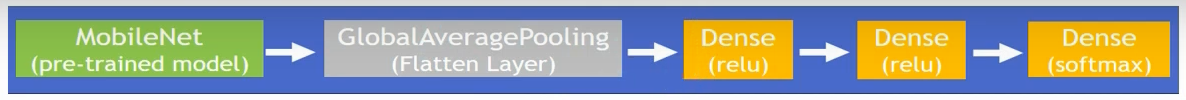

- 데이터의 개수가 3,160개로 매우 적기 때문에 전이 학습 (Transfer Learning)을 사용하여 모델을 구축할 것임
- 사전 학습 모델(Pre-Trained Model)로는 MobileNet을 사용하고, 오버피팅을 줄이고 정확도를 높이기 위해 출력층 앞에 두 개의 Dense layer를 추가할 것임
- 또한, 데이터를 살펴보면 Testing data와 Training data가 굉장히 이질적이다.
-  => 학습 전에 Training data와 Testing data를 혼합하여 shuffle해준 후 8 : 2 비율로 분리해 준 후 ImageDataGenerator로 데이터를 불러올 것임


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.__version__

In [ ]:
# 구글 코랩에 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
# 1. 데이터 다운로드
import shutil
import os

try:
    # 구글 드라이브(dataset 폴더)에 저장되어 있는 brain_tumor.zip 파일을 구글 코랩(content 폴더)으로 복사
    dataset_path = '/content/gdrive/My Drive/Colab Notebooks/dataset'
    shutil.copy(os.path.join(dataset_path, 'brain_tumor.zip'), '/content')

except Exception as err:
    print(str(err))

In [ ]:
# 프로그램 호환성을 높이기 위해 여러 디렉토리 경로를 변수에 저장
ROOT_DIR = '/content'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'brain_tumor')
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'Training')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'Testing')

In [ ]:
# 압축을 풀기 전에 먼저 동일한 이름을 가진 폴더(디렉토리)가 있을 경우 삭제해줌
if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)
    print(DATA_ROOT_DIR + ' is removed!!!')

In [ ]:
# 압축 파일 해제
import zipfile

with zipfile.ZipFile(os.path.join(ROOT_DIR, 'brain_tumor.zip'), 'r') as target_file:
    target_file.extractall(DATA_ROOT_DIR)

In [ ]:
# 2. 데이터 전처리(데이터 재구축)
# Testing 디렉토리의 모든 데이터를 동일한 이름의 Training 디렉토리로 이동
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list: # Testing 디렉토리의 각각의 Label에 대해서 반복
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    test_file_list = os.listdir(test_path) # label 디렉토리에 있는 이미지 파일 목록을 추출

    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    moved_num = 0
    
    for test_image_file in test_file_list: # 현재 label의 모든 이미지 파일에 대해 반복
        # Testing 디렉토리 이미지 파일을 동일한 label의 Training 디렉토리로 이동
        shutil.move(os.path.join(test_path, test_image_file), os.path.join(train_path, test_image_file))
        moved_num += 1

    print(str(moved_num) + ' is moved into ' + label_name + ' (Testing => Training)')

In [ ]:
import random

MOVE_RATIO = 0.2

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list: # Training 디렉토리의 각각의 label에 대해 반복
    # 파일을 move 하기 위한 src_dir_path, dst_dir_path 설정
    # ==========================================================
    src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    # ==========================================================

    train_data_file_list = os.listdir(src_dir_path) # label 디렉토리에 있는 모든 이미지 파일을 추출
    random.shuffle(train_data_file_list) # 데이터 다양성을 위해 전체 데이터를 shuffle 해줌

    split_num = int(MOVE_RATIO * len(train_data_file_list))
    test_data_file_list = train_data_file_list[0:split_num] # 전체 데이터에서 20% 만큼 test data 생성

    for test_data_file in test_data_file_list: # test data의 모든 이미지 파일에 대해 반복
        try:
            # Training 디렉토리에서 test data를 Testing 디렉토리로 이동
            shutil.move(os.path.join(src_dir_path, test_data_file), os.path.join(dst_dir_path, test_data_file))

        except Exception as err:
            print(str(err))


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# 이미지 데이터 정규화
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# 이미지 데이터 불러옴 (학습 데이터 개수가 매우 부족하기 때문에 별도의 validation data를 만들지 않고 test data를 validation 목적으로 사용)
IMG_WIDTH = 224
IMG_HEIGHT = 224

train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32, 
                                                    color_mode='rgb', class_mode='sparse', 
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT))
test_generator = train_datagen.flow_from_directory(TEST_DATA_ROOT_DIR, batch_size=32, 
                                                   color_mode='rgb', class_mode='sparse', 
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT))

In [ ]:
print(train_generator.class_indices)
print(train_generator.num_classes)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# 3. 모델 구축
class_nums = train_generator.num_classes # 정답 개수

pre_trained_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(class_nums, activation='softmax'))

model.compile(optimizer=Adam(2e-5), loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
hist = model.fit(train_generator, epochs=30, validation_data=test_generator, callbacks=[earlystopping])

In [ ]:
model.evaluate(test_generator)

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')

plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')

plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
pred = model.predict(train_generator[0:25])

In [ ]:
# plt.figure(figsize=(9,9))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.imshow(test_generator[i])
#     plt.title('pred : ' + str(label_name_list[pred[i]]) + '\nlabel:' + str())